In [1]:
############################################ Import Python Libraries Required ############################################ 
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors

import datetime
import os 
from os import path
import seaborn as sns
from scipy import signal

import warnings
warnings.filterwarnings('ignore')

import pickle

import statistics
import math 
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)
# %config InlineBackend.figure_format = 'retina'
from PIL import Image

############################# Update Actual Cases #############################################3
import requests
os.system("rm state_wise_daily.csv")
url = """https://data.covid19india.org/csv/latest/state_wise_daily.csv"""
response = requests.get(url)


with open( "state_wise_daily.csv", 'wb') as f:
    f.write(response.content)
df  = pd.read_csv("state_wise_daily.csv",delimiter=",")

listOfColumns  = ["Date","Date_YMD","Status","KA"]
df = df[listOfColumns].copy(deep=True)
df["Date"] = pd.to_datetime(df["Date"])

## Sum all the values upto Jul-1st 2020 and add that as cumuliative total to Jul-1st 2020
## The data fitted to the model starts only from Jul-1st 2020

## Sum of COnfirmed 
df_temp = df[(df["Date"] <= '2020-07-01') & (df["Status"]=="Confirmed")]
ConfirmVal = df_temp["KA"].cumsum().iloc[-1]
index = df.loc[(df["Date"] =='2020-07-01') & (df["Status"] == "Confirmed")]["KA"].index
df.loc[index,"KA"] = ConfirmVal

## Sum of COnfirmed  
df_temp = df[(df["Date"] <= '2020-07-01') & (df["Status"]=="Recovered")]
RecoverVal = df_temp["KA"].cumsum().iloc[-1]
index = df.loc[(df["Date"] =='2020-07-01') & (df["Status"] == "Recovered")]["KA"].index
df.loc[index,"KA"] = RecoverVal

## Sum of Deceased 
df_temp = df[(df["Date"] <= '2020-07-01') & (df["Status"]=="Deceased")]
DeceaseVal = df_temp["KA"].cumsum().iloc[-1]
index = df.loc[(df["Date"] =='2020-07-01') & (df["Status"] == "Deceased")]["KA"].index
## -2 , HARDCODED for adjustment with the data used to fir the model ( The current data we have has 253 as Total Deceased as)
df.loc[index,"KA"] = DeceaseVal - 2   


#Copy data only from Jun-01-2020
df = df[(df["Date"] >= '2020-07-01')].copy(deep=True)

##reset index of Dataframe
df.reset_index(inplace=True,drop=True)


## get the KA columns from the dataframe
totaldata_all = df.KA
totalDays  = int(len(totaldata_all)/3)

N_dataDays = totalDays

##Declare Arrays 
actualAct = np.zeros(N_dataDays) 
actualRecov = np.zeros(N_dataDays)  
actualTot = np.zeros(N_dataDays) 
actualDes = np.zeros(N_dataDays) 

## Get the first day data
MarInitTot = totaldata_all[0]
MarInitRecov = totaldata_all[1]
MarInitDes = totaldata_all[2]

##initial Setup
actualTot[0] = MarInitTot 
actualRecov[0] = MarInitRecov 
actualDes[0] = MarInitDes 
actualAct[0] = actualTot[0] - actualRecov[0] - actualDes[0]


for idx in range(1, N_dataDays):
    actualTot[idx] = actualTot[idx-1] + totaldata_all[3*(idx)]
    actualRecov[idx] = actualRecov[idx-1] + totaldata_all[3*(idx)+1]
    actualDes[idx] = actualDes[idx-1] + totaldata_all[3*(idx)+2]
    actualAct[idx] = actualTot[idx] - actualRecov[idx] - actualDes[idx]


ActualDict = {}
ActualDict["Actual"] = actualAct
ActualDict["Deceased"] = actualDes
ActualDict["Recovered"] = actualRecov
ActualDict["Cumuliative"] = actualTot

file_name = "Data_Files/actual_Data.pkl"

open_file = open(file_name, "wb")
pickle.dump(ActualDict, open_file)
open_file.close()

###################################### Actual Cases Updated ####################################################

###################################### Read Predicted and Actual Cases #########################################
df_active = pd.read_pickle("Data_Files/df_active")

with open('Data_Files/actual_Data.pkl', 'rb') as f: mynewlist = pickle.load(f) #actual number of active cases 



###################################### Read Ensemble Mean And Standard Errors ###################################
with open('Data_Files/ensemblemean.pkl', 'rb') as f:
    ensemble_mean = pickle.load(f)


with open('Data_Files/ensembleub.pkl', 'rb') as f:
    ensemble_ub = pickle.load(f)

with open('Data_Files/ensemblelb.pkl', 'rb') as f:
    ensemble_lb = pickle.load(f)



###################################### Update ###################################

N = 972
SF = 1e4
D = 0
weightp = np.zeros(N)

weightr = np.zeros(N)
weightr[:] = 1.0/N

with open('Data_Files/mse.pkl', 'rb') as f:
    MSE = pickle.load(f)

lastDay = pd.read_pickle('Data_Files/day.pkl')
latestDay = lastDay

RMSE = np.zeros(N)

for i in range(N):
    for j in range(lastDay+1,len(mynewlist['Actual'])-D):
        MSE[i] += (((df_active.iloc[i,j]-mynewlist['Actual'][j])/SF)**2)/(len(mynewlist['Actual'])-D)
        latestDay = j
        
for i in range(N):
    RMSE[i] = math.sqrt(MSE[i])
    weightr[i] = np.exp(-1.0*RMSE[i])*weightr[i]
    

sum_weightr = sum(weightr)


for i in range(N):
    weightr[i] = (weightr[i]/sum_weightr)*N

# with open('Data_Files/wpcum.pkl', 'rb') as f:
#     # weightpcum = pickle.load(f)

p25 = np.percentile(weightr,25)
p50 = np.percentile(weightr,50)
p75 = np.percentile(weightr,75)

max_list = [i for i, j in enumerate(weightr) if j == max(weightr)]


for i in range(N):
    if(weightr[i]<p25):
        weightp[i]=0
    elif(p25<=weightr[i]<p50):
        weightp[i]=0.25
    elif(p50<=weightr[i]<p75):
        weightp[i]=0.5
    else:
        weightp[i]=0.75
    
for i in max_list:
    weightp[i] = 1.0   

# weightpcum.append(weightp)



df_posterior = df_active.copy(deep=True)
df_posterior['WeightRMSE'] = weightr
for i in range(N):
    for j in range(731):    
        df_posterior.iloc[i,j] = df_posterior.iloc[i,j]*df_posterior['WeightRMSE'][i]


weighted_mean= []
weighted_sem = []
weighted_ub = []
weighted_lb = []



for i in range(731):
    
    weighted_mean.append(np.mean(df_posterior.iloc[:,i]))
    weighted_sem.append(scipy.stats.sem(df_posterior.iloc[:,i]))
    weighted_ub.append(weighted_mean[i]+weighted_sem[i])
    weighted_lb.append(weighted_mean[i]-weighted_sem[i])



   




###################################### Update Input Files ###################################
with open('Data_Files/mse.pkl', 'wb') as f:
    pickle.dump(MSE, f)

with open('Data_Files/day.pkl','wb') as f:
    pickle.dump(latestDay,f)       
        
###################################### Update Output Files ###################################
with open('Data_Files/wm.pkl', 'wb') as f:
    pickle.dump(weighted_mean, f)

with open('Data_Files/wub.pkl','wb') as f:
    pickle.dump(weighted_ub,f)

with open('Data_Files/wlb.pkl','wb') as f:
    pickle.dump(weighted_lb,f)

with open('Data_Files/wr.pkl','wb') as f:
    pickle.dump(weightr,f)

# with open('Data_Files/wpcum.pkl','wb') as f:
#     pickle.dump(weightpcum,f)




In [2]:
df_posterior['WeightN']=weightr/N
df_weight = df_posterior.copy(deep=True)
df1 = df_weight[df_weight['KDPwsat2']=='ImmunEscp_Jul']
df2 = df_weight[df_weight['KDPwsat2']=='ImmunEscp_Sep']
df3 = df_weight[df_weight['KDPwsat2']=='ImmunEscp_Nov']
id = []
imm = []
for i in range(N):
    id.append(i+1)
for i in range(0,int(N/3)):
    imm.append('IENV-Jul21')
for i in range(int(N/3),int(2*N/3)):
    imm.append('IENV-Sep21')
for i in range(int(2*N/3),N):
    imm.append('IENV-Nov21')

df_final = df1.append(df2.append(df3))
df_final['Ensemble Number'] = id
df_final['IENV'] = imm
df_final

,0,1,2,3,4,5,6,7,8,9,...,KDPg1,KDPg2,Scenario,Date Of Peak,Number At Peak,LogNumAtPeak,WeightRMSE,WeightN,Ensemble Number,IENV
Total,5254.174025,5945.327118,6483.887970,6969.233880,7453.938647,7962.365737,8506.696883,9091.420094,9719.741088,10392.942153,...,0_33,ABW150Days,1,670,2.0,0.301030,0.641144,0.000660,1,IENV-Jul21
Total,5414.811491,6127.095419,6682.121856,7182.306395,7681.830188,8205.801575,8766.774724,9369.374856,10016.905699,10710.688745,...,0_33,ABW150Days,2,558,172270.0,5.236210,0.660746,0.000680,2,IENV-Jul21
Total,2429.142860,2748.681115,2997.671964,3222.060145,3446.151908,3681.211126,3932.869733,4203.202654,4493.691978,4804.930538,...,0_33,ABW150Days,3,437,98844.0,4.994950,0.296418,0.000305,3,IENV-Jul21
Total,5249.143908,5939.635321,6477.680579,6962.561840,7446.802572,7954.742916,8498.552943,9082.716366,9710.435832,10382.992404,...,0_33,ABW150Days,4,670,2.0,0.301030,0.640530,0.000659,4,IENV-Jul21
Total,5387.227402,6095.882818,6648.081844,7145.718347,7642.697471,8163.999646,8722.115090,9321.645461,9965.877658,10656.126441,...,0_33,ABW150Days,5,576,85952.0,4.934256,0.657380,0.000676,5,IENV-Jul21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Total,14636.294176,16559.819353,18056.489825,19404.922053,20749.782274,22158.938602,23664.539089,25280.871759,27015.080623,28868.951685,...,1_00,ABW180Days,968,630,47632.0,4.677899,1.786003,0.001837,968,IENV-Nov21
Total,14907.220593,16866.351354,18390.726077,19764.118578,21133.872954,22569.113594,24102.583632,25748.835570,27515.145662,29403.332968,...,1_00,ABW180Days,969,545,1998940.0,6.300800,1.819063,0.001871,969,IENV-Nov21
Total,14507.043084,16413.581876,17897.035458,19233.559867,20566.543813,21963.256076,23455.560813,25057.619872,26776.514178,28614.013961,...,1_00,ABW180Days,970,670,2.0,0.301030,1.770231,0.001821,970,IENV-Nov21
Total,14642.709637,16567.077945,18064.404446,19413.427725,20758.877433,22168.651430,23674.911860,25291.953010,27026.922022,28881.605684,...,1_00,ABW180Days,971,670,2.0,0.301030,1.786786,0.001838,971,IENV-Nov21


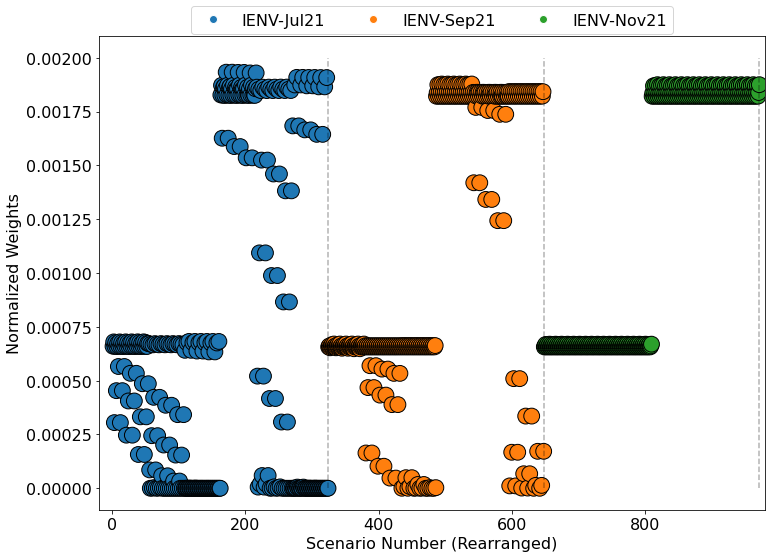

In [3]:
from matplotlib.lines import Line2D
###################################### Plotting ###################################
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize']=16

fig, ax = plt.subplots(figsize=(11,8))
plt.rcParams["font.serif"]
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors = {'IENV-Jul21':'tab:blue','IENV-Sep21':'tab:orange','IENV-Nov21':'tab:green'}
ax.scatter(df_final['Ensemble Number'],df_final['WeightN'],c=df_final['IENV'].map(colors),s=250,edgecolors='k')
plt.plot([324,324],[0,0.002],'k--',alpha=0.3)
plt.plot([648,648],[0,0.002],'k--',alpha=0.3)
plt.plot([972,972],[0,0.002],'k--',alpha=0.3)
handles = [Line2D([0],[0],marker='o',color='w',markerfacecolor=v,label=k,markersize=8) for k,v in colors.items()]
ax.legend(title=None, handles=handles,ncol=3,loc='upper center',bbox_to_anchor=(0.5,1.08))
ax.set_xlim(-20,980)
ax.set_ylabel('Normalized Weights')
ax.set_xlabel('Scenario Number (Rearranged)')

plt.tight_layout()

name = "Output_Files/Images/Weights_Day_" + str(latestDay)+".png"
plt.savefig(name,dpi=600,bbox_inches='tight')

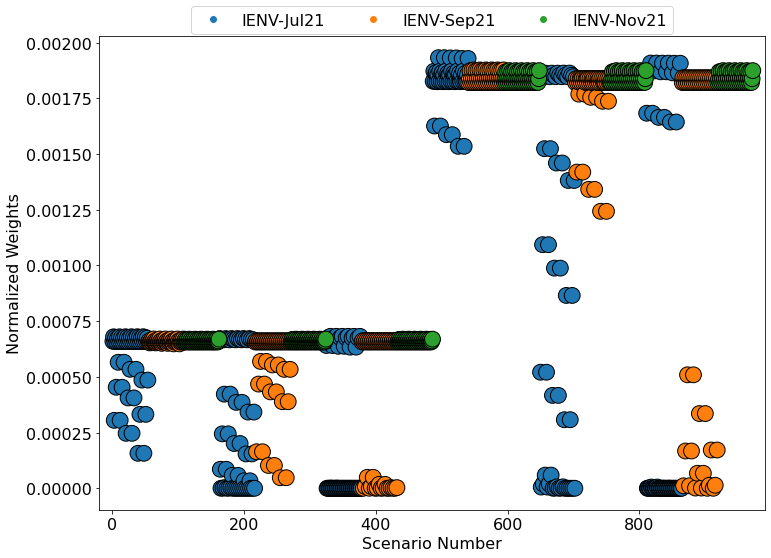

In [4]:
from matplotlib.lines import Line2D
###################################### Plotting ###################################
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize']=16

fig, ax = plt.subplots(figsize=(11,8))
plt.rcParams["font.serif"]
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors = {'IENV-Jul21':'tab:blue','IENV-Sep21':'tab:orange','IENV-Nov21':'tab:green'}
ax.scatter(df_final['Scenario'],df_final['WeightN'],c=df_final['IENV'].map(colors),s=250,edgecolors='k')
# plt.plot([324,324],[0,0.002],'k--',alpha=0.3)
# plt.plot([648,648],[0,0.002],'k--',alpha=0.3)
# plt.plot([972,972],[0,0.002],'k--',alpha=0.3)
handles = [Line2D([0],[0],marker='o',color='w',markerfacecolor=v,label=k,markersize=8) for k,v in colors.items()]
ax.legend(title=None, handles=handles,ncol=3,loc='upper center',bbox_to_anchor=(0.5,1.08))
ax.set_xlim(-20,990)
ax.set_ylabel('Normalized Weights')
ax.set_xlabel('Scenario Number')
plt.tight_layout()

name = "Output_Files/Images/Weights1_Day_" + str(latestDay)+".png"
plt.savefig(name,dpi=600,bbox_inches='tight')

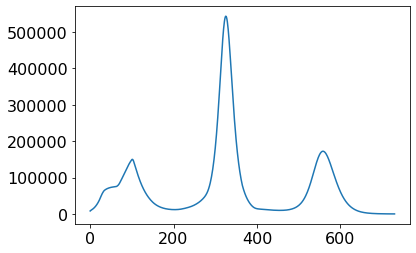

In [5]:
df_temp = df_active.copy(deep=True)
df_temp = df_temp[df_temp['KDPwsat2']=='ImmunEscp_Jul']
plt.plot(df_temp.iloc[1,0:731])

No handles with labels found to put in legend.


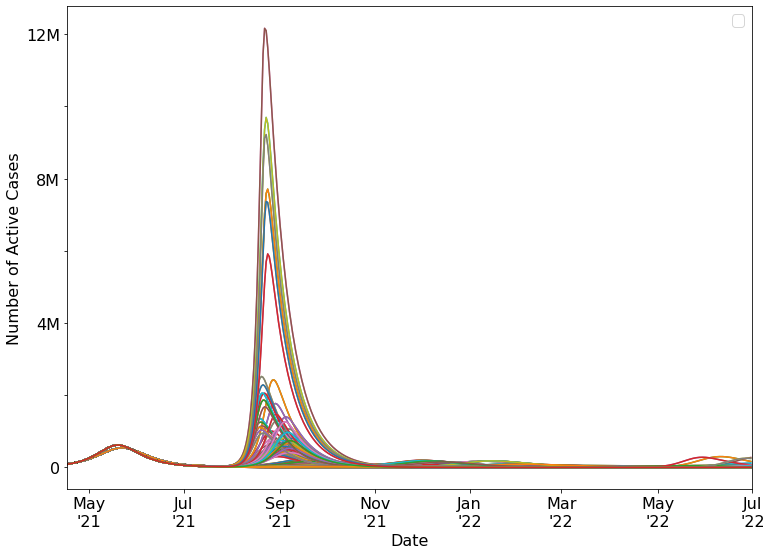

In [6]:
###################################### Plotting ###################################
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize']=16

fig, ax = plt.subplots(figsize=(11,8))
plt.rcParams["font.serif"]
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
startDay=301
xt = [304,365,427,488,549,608,670,731]   ## 1st days of the months hardcoded 
xtl = ['May\n\'21','Jul\n\'21','Sep\n\'21','Nov\n\'21', 'Jan\n\'22','Mar\n\'22','May\n\'22','Jul\n\'22']
yt=[0,2e6,4e6,6e6,8e6,10e6,12e6]
ytl=['0','','4M','','8M','','12M']
for i in range(len(df_temp)):
    plt.plot(df_temp.iloc[i,0:731])

plt.xlim([290,730])
plt.xticks(ticks=xt,labels=xtl)
plt.yticks(ticks=yt,labels=ytl)
plt.xlabel('Date')
plt.ylabel('Number of Active Cases')
plt.legend()
plt.tight_layout()

No handles with labels found to put in legend.


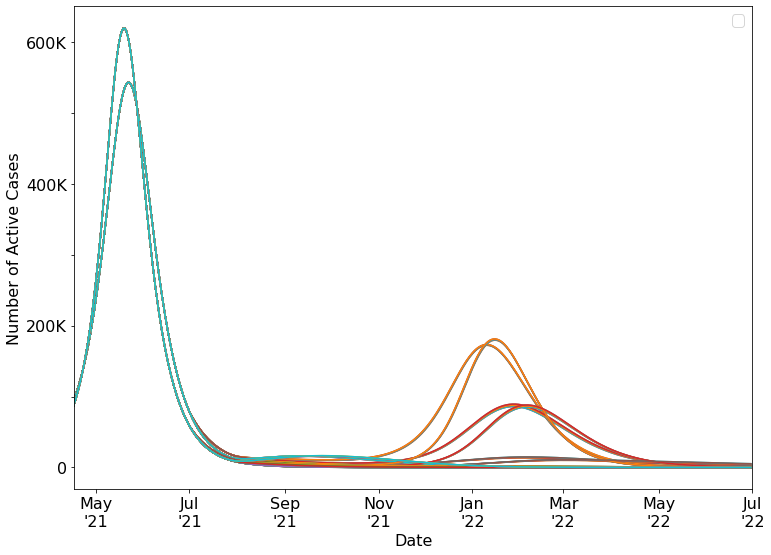

In [7]:
###################################### Plotting ###################################
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize']=16

fig, ax = plt.subplots(figsize=(11,8))
plt.rcParams["font.serif"]
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16
strg = 'Observed Cases:\n'
lp=0
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
startDay=301
xt = [304,365,427,488,549,608,670,731]   ## 1st days of the months hardcoded 
xtl = ['May\n\'21','Jul\n\'21','Sep\n\'21','Nov\n\'21', 'Jan\n\'22','Mar\n\'22','May\n\'22','Jul\n\'22']
yt=[0,1e5,2e5,3e5,4e5,5e5,6e5]
ytl=['0','','200K','','400K','','600K']
for i in range(len(df_temp)):
    if(max(df_temp.iloc[i,400:487])<=2e4):
        plt.plot(df_temp.iloc[i,0:731])
        strg+=df_temp['ID'][i]+'\n'
        lp+=1
# plt.text(450,3e5,str(lp))

plt.xlim([290,730])
plt.xticks(ticks=xt,labels=xtl)
plt.yticks(ticks=yt,labels=ytl)
plt.xlabel('Date')
plt.ylabel('Number of Active Cases')
plt.legend()
plt.tight_layout()
# plt.savefig('a.png',dpi=600,bbox_to_inhes='tight',facecolor='w')

No handles with labels found to put in legend.


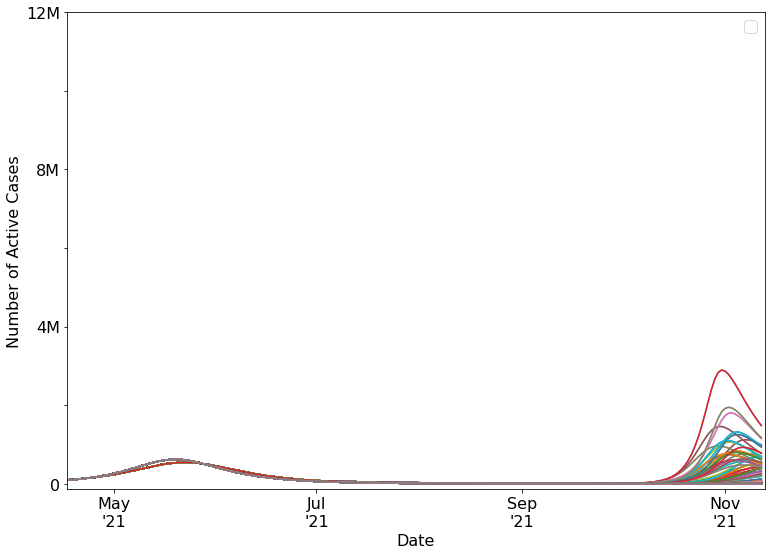

In [8]:
df_temp1 = df_active.copy(deep=True)
df_temp2 = df_active.copy(deep=True)
df_temp1 = df_temp1[df_temp1['KDPwsat2']=='ImmunEscp_Jul']
df_temp2 = df_temp2[df_temp2['KDPwsat2']!='ImmunEscp_Jul']
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize']=16

fig, ax = plt.subplots(figsize=(11,8))
plt.rcParams["font.serif"]
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16
strg = 'Observed Cases:\n'
lp=0
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
startDay=301
xt = [304,365,427,488]#,549,608,670,731]   ## 1st days of the months hardcoded 
xtl = ['May\n\'21','Jul\n\'21','Sep\n\'21','Nov\n\'21']#, 'Jan\n\'22','Mar\n\'22','May\n\'22','Jul\n\'22']
yt=[0,2e6,4e6,6e6,8e6,10e6,12e6]
ytl=['0','','4M','','8M','','12M']
for i in range(len(df_temp)):
    if(max(df_temp.iloc[i,400:487])<=2e4):
        plt.plot(df_temp.iloc[i,0:500],linestyle='dashed')
        strg+=df_temp['ID'][i]+'\n'
        lp+=1
        
for i in range(len(df_temp2)):
    plt.plot(df_temp2.iloc[i,0:500])
# plt.text(450,3e5,str(lp))

plt.xlim([290,500])
plt.xticks(ticks=xt,labels=xtl)
plt.yticks(ticks=yt,labels=ytl)
plt.xlabel('Date')
plt.ylabel('Number of Active Cases')
plt.legend()
plt.tight_layout()
# plt.savefig('a.png',dpi=600,bbox_to_inhes='tight',facecolor='w')

In [9]:
N = len(df_temp2)
SF = 1e4
D = 0
weightp1 = np.zeros(N)

weightr1 = np.zeros(N)
weightr1[:] = 1.0/N

# with open('Data_Files/mse.pkl', 'rb') as f:
#     MSE = pickle.load(f)

lastDay = pd.read_pickle('Data_Files/day.pkl')
latestDay = lastDay
MSE1=np.zeros(N)
RMSE1 = np.zeros(N)

for i in range(N):
    for j in range(lastDay+1,len(mynewlist['Actual'])-D):
        MSE1[i] += (((df_temp2.iloc[i,j]-mynewlist['Actual'][j])/SF)**2)/(len(mynewlist['Actual'])-D)
        latestDay = j
        
for i in range(N):
    RMSE1[i] = math.sqrt(MSE1[i])
    weightr1[i] = np.exp(-1.0*RMSE1[i])*weightr1[i]
    

sum_weightr1 = sum(weightr1)


for i in range(N):
    weightr1[i] = (weightr1[i]/sum_weightr1)*N

# with open('Data_Files/wpcum.pkl', 'rb') as f:
#     # weightpcum = pickle.load(f)

# p25 = np.percentile(weightr,25)
# p50 = np.percentile(weightr,50)
# p75 = np.percentile(weightr,75)

# max_list = [i for i, j in enumerate(weightr) if j == max(weightr)]


# for i in range(N):
#     if(weightr[i]<p25):
#         weightp[i]=0
#     elif(p25<=weightr[i]<p50):
#         weightp[i]=0.25
#     elif(p50<=weightr[i]<p75):
#         weightp[i]=0.5
#     else:
#         weightp[i]=0.75
    
# for i in max_list:
#     weightp[i] = 1.0   

# # weightpcum.append(weightp)



df_posterior1 = df_temp2.copy(deep=True)
df_posterior1['WeightRMSE'] = weightr1
for i in range(len(df_temp2)):
    for j in range(731):    
        df_posterior1.iloc[i,j] = df_posterior1.iloc[i,j]*df_posterior1['WeightRMSE'][i]


weighted_mean1= []
weighted_sem1 = []
weighted_ub1 = []
weighted_lb1= []



for i in range(731):
    
    weighted_mean1.append(np.mean(df_posterior1.iloc[:,i]))
    weighted_sem1.append(scipy.stats.sem(df_posterior1.iloc[:,i]))
    weighted_ub1.append(weighted_mean1[i]+weighted_sem1[i])
    weighted_lb1.append(weighted_mean1[i]-weighted_sem1[i])



In [1]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize']=18

plt.figure(figsize=(11,8))
plt.rcParams["font.serif"]
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

startDay=301
xt = [304,365,427,488,549,608,670,731]   ## 1st days of the months hardcoded 
xtl = ['May\n\'21','Jul\n\'21','Sep\n\'21','Nov\n\'21', 'Jan\n\'22','Mar\n\'22','May\n\'22','Jul\n\'22']
yt=[0,1e5,2e5,3e5,4e5,5e5,6e5]
ytl=['0','','200K','','400K','','600K']
plt.plot(mynewlist['Actual'],'k-',label='Actual Data')
plt.plot(ensemble_mean,'r-', label='Ensemble Mean')
plt.fill_between(np.arange(731),ensemble_ub,ensemble_lb,color='r',alpha=0.4)
plt.plot(weighted_mean1,'b--',label='Posterior Mean (w/o IENV-Jul21)')
plt.fill_between(np.arange(731),weighted_ub1,weighted_lb1,color='b',alpha=0.4)
plt.plot(weighted_mean,'g-',label='Posterior Mean (w IENV-Jul21)')
plt.fill_between(np.arange(731),weighted_ub,weighted_lb,color='g',alpha=0.2)
plt.xlim([290,730])
plt.xticks(ticks=xt,labels=xtl)
plt.yticks(ticks=yt,labels=ytl)
plt.xlabel('Date')
plt.ylabel('Number of Active Cases')
plt.legend()

NameError: name 'plt' is not defined

In [11]:
df_temp3=df_temp2.copy(deep=True)
df_temp3=df_temp3[df_temp3['KDPwsat2']!='ImmunEscp_Sep']
N = len(df_temp3)
SF = 1e4
D = 0
weightp2 = np.zeros(N)

weightr2 = np.zeros(N)
weightr2[:] = 1.0/N

# with open('Data_Files/mse.pkl', 'rb') as f:
#     MSE = pickle.load(f)

lastDay = pd.read_pickle('Data_Files/day.pkl')
latestDay = lastDay
MSE2=np.zeros(N)
RMSE2 = np.zeros(N)

for i in range(N):
    for j in range(lastDay+1,len(mynewlist['Actual'])-D):
        MSE2[i] += (((df_temp3.iloc[i,j]-mynewlist['Actual'][j])/SF)**2)/(len(mynewlist['Actual'])-D)
        latestDay = j
        
for i in range(N):
    RMSE2[i] = math.sqrt(MSE2[i])
    weightr2[i] = np.exp(-1.0*RMSE2[i])*weightr2[i]
    

sum_weightr2 = sum(weightr2)


for i in range(N):
    weightr2[i] = (weightr2[i]/sum_weightr2)*N

# with open('Data_Files/wpcum.pkl', 'rb') as f:
#     # weightpcum = pickle.load(f)

# p25 = np.percentile(weightr,25)
# p50 = np.percentile(weightr,50)
# p75 = np.percentile(weightr,75)

# max_list = [i for i, j in enumerate(weightr) if j == max(weightr)]


# for i in range(N):
#     if(weightr[i]<p25):
#         weightp[i]=0
#     elif(p25<=weightr[i]<p50):
#         weightp[i]=0.25
#     elif(p50<=weightr[i]<p75):
#         weightp[i]=0.5
#     else:
#         weightp[i]=0.75
    
# for i in max_list:
#     weightp[i] = 1.0   

# # weightpcum.append(weightp)



df_posterior2 = df_temp3.copy(deep=True)
df_posterior2['WeightRMSE'] = weightr2
for i in range(len(df_temp3)):
    for j in range(731):    
        df_posterior2.iloc[i,j] = df_posterior2.iloc[i,j]*df_posterior2['WeightRMSE'][i]


weighted_mean2= []
weighted_sem2 = []
weighted_ub2 = []
weighted_lb2= []



for i in range(731):
    
    
    weighted_mean2.append(np.mean(df_posterior2.iloc[:,i]))
    weighted_sem2.append(scipy.stats.sem(df_posterior2.iloc[:,i]))
    weighted_ub2.append(weighted_mean2[i]+weighted_sem2[i])
    weighted_lb2.append(weighted_mean2[i]-weighted_sem2[i])

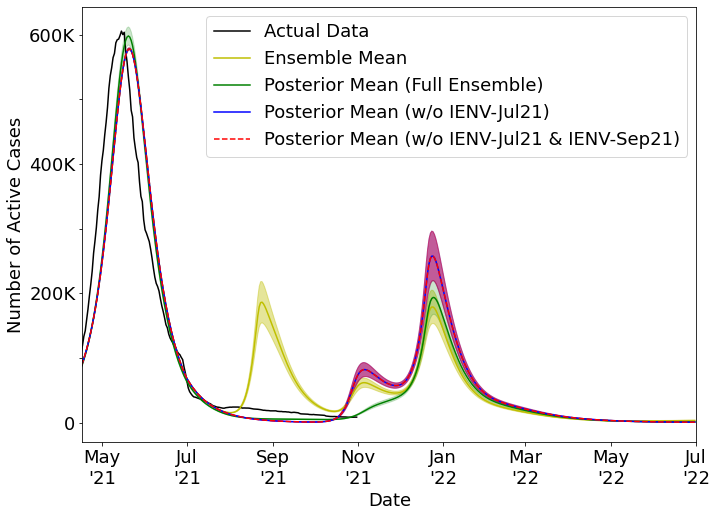

In [12]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize']=18

plt.figure(figsize=(11,8))
plt.rcParams["font.serif"]
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

startDay=301
xt = [304,365,427,488,549,608,670,731]   ## 1st days of the months hardcoded 
xtl = ['May\n\'21','Jul\n\'21','Sep\n\'21','Nov\n\'21', 'Jan\n\'22','Mar\n\'22','May\n\'22','Jul\n\'22']
yt=[0,1e5,2e5,3e5,4e5,5e5,6e5]
ytl=['0','','200K','','400K','','600K']
plt.plot(mynewlist['Actual'],'k-',label='Actual Data')
plt.plot(ensemble_mean,'y-', label='Ensemble Mean')
plt.fill_between(np.arange(731),ensemble_ub,ensemble_lb,color='y',alpha=0.4)
plt.plot(weighted_mean,'g-',label='Posterior Mean (Full Ensemble)')
plt.fill_between(np.arange(731),weighted_ub,weighted_lb,color='g',alpha=0.2)
plt.plot(weighted_mean1,'b-',label='Posterior Mean (w/o IENV-Jul21)')
plt.fill_between(np.arange(731),weighted_ub1,weighted_lb1,color='b',alpha=0.4)

plt.plot(weighted_mean1,'r--',label='Posterior Mean (w/o IENV-Jul21 & IENV-Sep21)')
plt.fill_between(np.arange(731),weighted_ub1,weighted_lb1,color='r',alpha=0.4)
plt.xlim([290,730])
plt.xticks(ticks=xt,labels=xtl)
plt.yticks(ticks=yt,labels=ytl)
plt.xlabel('Date')
plt.ylabel('Number of Active Cases')
plt.legend()

In [16]:
max_list1 = [i for i, j in enumerate(weightr1) if j == max(weightr1)]
# for i in max_list1:
#     plt.plot(df_temp2.iloc[i,0:731])

len(max_list1)

648

In [17]:
df_posterior1['WeightN']=weightr1/len(weightr1)
df_weight1 = df_posterior1.copy(deep=True)

df21 = df_weight1[df_weight1['KDPwsat2']=='ImmunEscp_Sep']
df31 = df_weight1[df_weight1['KDPwsat2']=='ImmunEscp_Nov']
id1 = []
imm1 = []
for i in range(len(weightr1)):
    id1.append(i+1)
for i in range(0,int(len(weightr1)/2)):
    imm1.append('IENV-Sep21')
for i in range(int(len(weightr1)/2),len(weightr1)):
    imm1.append('IENV-Nov21')

df_final1 = df21.append(df31)
df_final1['Ensemble Number'] = id1
df_final1['IENV'] = imm1
df_final1

,0,1,2,3,4,5,6,7,8,9,...,KDPg1,KDPg2,Scenario,Date Of Peak,Number At Peak,LogNumAtPeak,WeightRMSE,WeightN,Ensemble Number,IENV
Total,8195.0,9273.0,10113.0,10870.0,11626.0,12419.0,13268.0,14180.0,15160.0,16210.0,...,0_33,ABW150Days,55,670,2.0,0.301030,1.0,0.001543,1,IENV-Sep21
Total,8195.0,9273.0,10113.0,10870.0,11626.0,12419.0,13268.0,14180.0,15160.0,16210.0,...,0_33,ABW150Days,56,581,202200.0,5.305781,1.0,0.001543,2,IENV-Sep21
Total,8195.0,9273.0,10113.0,10870.0,11626.0,12419.0,13268.0,14180.0,15160.0,16210.0,...,0_33,ABW150Days,57,513,394391.0,5.595927,1.0,0.001543,3,IENV-Sep21
Total,8195.0,9273.0,10113.0,10870.0,11626.0,12419.0,13268.0,14180.0,15160.0,16210.0,...,0_33,ABW150Days,58,670,2.0,0.301030,1.0,0.001543,4,IENV-Sep21
Total,8195.0,9273.0,10113.0,10870.0,11626.0,12419.0,13268.0,14180.0,15160.0,16210.0,...,0_33,ABW150Days,59,605,66841.0,4.825043,1.0,0.001543,5,IENV-Sep21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Total,8195.0,9272.0,10110.0,10865.0,11618.0,12407.0,13250.0,14155.0,15126.0,16164.0,...,1_00,ABW180Days,968,630,47632.0,4.677899,1.0,0.001543,644,IENV-Nov21
Total,8195.0,9272.0,10110.0,10865.0,11618.0,12407.0,13250.0,14155.0,15126.0,16164.0,...,1_00,ABW180Days,969,545,1998940.0,6.300800,1.0,0.001543,645,IENV-Nov21
Total,8195.0,9272.0,10110.0,10865.0,11618.0,12407.0,13250.0,14155.0,15126.0,16164.0,...,1_00,ABW180Days,970,670,2.0,0.301030,1.0,0.001543,646,IENV-Nov21
Total,8195.0,9272.0,10110.0,10865.0,11618.0,12407.0,13250.0,14155.0,15126.0,16164.0,...,1_00,ABW180Days,971,670,2.0,0.301030,1.0,0.001543,647,IENV-Nov21


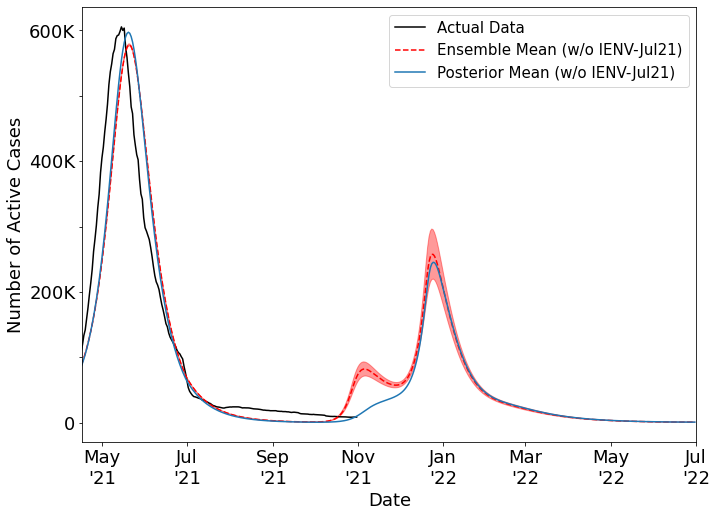

In [33]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize']=18

plt.figure(figsize=(11,8))
plt.rcParams["font.serif"]
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ensemble_mean1 = []
ensemble_sem1 = []
ensemble_ub1 = []
ensemble_lb1 = []
for i in range(731):
    ensemble_mean1.append(np.mean(df_temp2.iloc[:,i]))
    ensemble_sem1.append(scipy.stats.sem(df_temp2.iloc[:,i]))
    ensemble_ub1.append(ensemble_mean1[i]+ensemble_sem1[i])
    ensemble_lb1.append(ensemble_mean1[i]-ensemble_sem1[i])

startDay=301
xt = [304,365,427,488,549,608,670,731]   ## 1st days of the months hardcoded 
xtl = ['May\n\'21','Jul\n\'21','Sep\n\'21','Nov\n\'21', 'Jan\n\'22','Mar\n\'22','May\n\'22','Jul\n\'22']
yt=[0,1e5,2e5,3e5,4e5,5e5,6e5]
ytl=['0','','200K','','400K','','600K']
plt.plot(mynewlist['Actual'],'k-',label='Actual Data')
plt.plot(ensemble_mean1,'r--', label='Ensemble Mean (w/o IENV-Jul21)')
plt.fill_between(np.arange(731),ensemble_ub1,ensemble_lb1,color='r',alpha=0.4)
N = len(df_temp2)
ScF = [1e4]
ScFn = ['1e4']

for k in range(len(ScF)):
    SF = ScF[k]
    D = 0
    weightp1 = np.zeros(N)

    weightr1 = np.zeros(N)
    weightr1[:] = 1.0/N

    # with open('Data_Files/mse.pkl', 'rb') as f:
    #     MSE = pickle.load(f)

    # lastDay = pd.read_pickle('Data_Files/day.pkl')
    # latestDay = lastDay
    MSE1=np.zeros(N)
    RMSE1 = np.zeros(N)

    for i in range(N):
        for j in range(0,len(mynewlist['Actual'])-D):
            MSE1[i] += (((df_temp2.iloc[i,j]-mynewlist['Actual'][j])/SF)**2)/(len(mynewlist['Actual'])-D)
            # latestDay = j
            
    for i in range(N):
        RMSE1[i] = math.sqrt(MSE1[i])
        weightr1[i] = np.exp(-1.0*RMSE1[i])*weightr1[i]
        

    sum_weightr1 = sum(weightr1)


    for i in range(N):
        weightr1[i] = (weightr1[i]/sum_weightr1)*N

    # with open('Data_Files/wpcum.pkl', 'rb') as f:
    #     # weightpcum = pickle.load(f)

    # p25 = np.percentile(weightr,25)
    # p50 = np.percentile(weightr,50)
    # p75 = np.percentile(weightr,75)

    # max_list = [i for i, j in enumerate(weightr) if j == max(weightr)]


    # for i in range(N):
    #     if(weightr[i]<p25):
    #         weightp[i]=0
    #     elif(p25<=weightr[i]<p50):
    #         weightp[i]=0.25
    #     elif(p50<=weightr[i]<p75):
    #         weightp[i]=0.5
    #     else:
    #         weightp[i]=0.75
        
    # for i in max_list:
    #     weightp[i] = 1.0   

    # # weightpcum.append(weightp)



    df_posterior1 = df_temp2.copy(deep=True)
    df_posterior1['WeightRMSE'] = weightr1
    for i in range(len(df_temp2)):
        for j in range(731):    
            df_posterior1.iloc[i,j] = df_posterior1.iloc[i,j]*df_posterior1['WeightRMSE'][i]


    weighted_mean1= []
    weighted_sem1 = []
    weighted_ub1 = []
    weighted_lb1= []



    for i in range(731):
        
        weighted_mean1.append(np.mean(df_posterior1.iloc[:,i]))
        weighted_sem1.append(scipy.stats.sem(df_posterior1.iloc[:,i]))
        weighted_ub1.append(weighted_mean1[i]+weighted_sem1[i])
        weighted_lb1.append(weighted_mean1[i]-weighted_sem1[i])

    plt.plot(weighted_mean1,label='Posterior Mean (w/o IENV-Jul21)')
    # plt.fill_between(np.arange(731),weighted_ub1,weighted_lb1,color='b',alpha=0.4)
plt.xlim([290,730])
plt.xticks(ticks=xt,labels=xtl)
plt.yticks(ticks=yt,labels=ytl)
plt.xlabel('Date')
plt.ylabel('Number of Active Cases')
plt.legend()

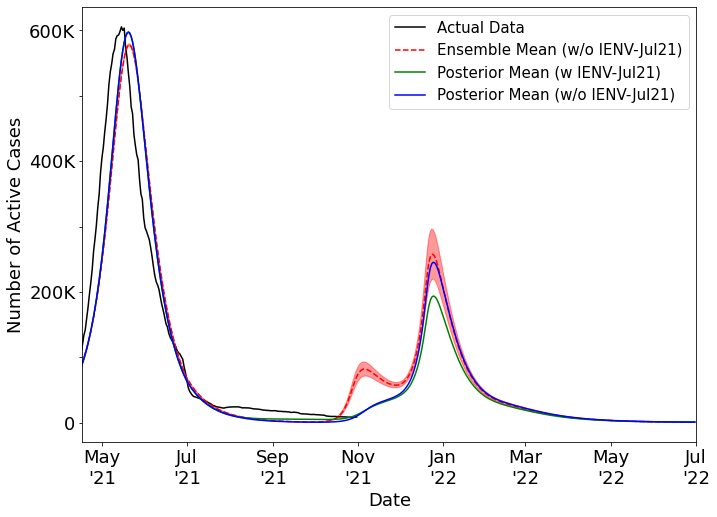

In [36]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize']=18

plt.figure(figsize=(11,8))
plt.rcParams["font.serif"]
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ensemble_mean1 = []
ensemble_sem1 = []
ensemble_ub1 = []
ensemble_lb1 = []
for i in range(731):
    ensemble_mean1.append(np.mean(df_temp2.iloc[:,i]))
    ensemble_sem1.append(scipy.stats.sem(df_temp2.iloc[:,i]))
    ensemble_ub1.append(ensemble_mean1[i]+ensemble_sem1[i])
    ensemble_lb1.append(ensemble_mean1[i]-ensemble_sem1[i])

startDay=301
xt = [304,365,427,488,549,608,670,731]   ## 1st days of the months hardcoded 
xtl = ['May\n\'21','Jul\n\'21','Sep\n\'21','Nov\n\'21', 'Jan\n\'22','Mar\n\'22','May\n\'22','Jul\n\'22']
yt=[0,1e5,2e5,3e5,4e5,5e5,6e5]
ytl=['0','','200K','','400K','','600K']
plt.plot(mynewlist['Actual'],'k-',label='Actual Data')
plt.plot(ensemble_mean1,'r--', label='Ensemble Mean (w/o IENV-Jul21)')
plt.fill_between(np.arange(731),ensemble_ub1,ensemble_lb1,color='r',alpha=0.4)
plt.plot(weighted_mean,'g-',label='Posterior Mean (w IENV-Jul21)')
# plt.fill_between(np.arange(731),weighted_ub,weighted_lb,color='g',alpha=0.4)
plt.plot(weighted_mean1,'b-',label='Posterior Mean (w/o IENV-Jul21)')
# plt.fill_between(np.arange(731),weighted_ub1,weighted_lb1,color='b',alpha=0.4)
plt.xlim([290,730])
plt.xticks(ticks=xt,labels=xtl)
plt.yticks(ticks=yt,labels=ytl)
plt.xlabel('Date')

plt.ylabel('Number of Active Cases')
plt.legend()

In [30]:
df_posterior1['WeightN']=weightr1/len(weightr1)
df_weight1 = df_posterior1.copy(deep=True)

df21 = df_weight1[df_weight1['KDPwsat2']=='ImmunEscp_Sep']
df31 = df_weight1[df_weight1['KDPwsat2']=='ImmunEscp_Nov']
id1 = []
imm1 = []
for i in range(len(weightr1)):
    id1.append(i+1)
for i in range(0,int(len(weightr1)/2)):
    imm1.append('IENV-Sep21')
for i in range(int(len(weightr1)/2),len(weightr1)):
    imm1.append('IENV-Nov21')

df_final1 = df21.append(df31)
df_final1['Ensemble Number'] = id1
df_final1['IENV'] = imm1
df_final1

,0,1,2,3,4,5,6,7,8,9,...,KDPg1,KDPg2,Scenario,Date Of Peak,Number At Peak,LogNumAtPeak,WeightRMSE,WeightN,Ensemble Number,IENV
Total,4670.248974,5284.590450,5763.298094,6194.704863,6625.541742,7077.464553,7561.301207,8081.040934,8639.533185,9237.917740,...,0_33,ABW150Days,55,670,2.0,0.301030,0.569890,0.000879,1,IENV-Sep21
Total,4702.463681,5321.042796,5803.052496,6237.435047,6671.243777,7126.283887,7613.457976,8136.782793,8699.127443,9301.639568,...,0_33,ABW150Days,56,581,202200.0,5.305781,0.573821,0.000886,2,IENV-Sep21
Total,4638.418619,5248.573015,5724.017999,6152.484490,6580.384975,7029.227680,7509.766717,8025.964127,8580.649941,9174.956171,...,0_33,ABW150Days,57,513,394391.0,5.595927,0.566006,0.000873,3,IENV-Sep21
Total,4670.687621,5285.086798,5763.839403,6195.286692,6626.164036,7078.129294,7562.011391,8081.799934,8640.344641,9238.785397,...,0_33,ABW150Days,58,670,2.0,0.301030,0.569944,0.000880,4,IENV-Sep21
Total,4703.327026,5322.019709,5804.117903,6238.580204,6672.468579,7127.592232,7614.855764,8138.276660,8700.724553,9303.347296,...,0_33,ABW150Days,59,605,66841.0,4.825043,0.573926,0.000886,5,IENV-Sep21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Total,12781.591780,14461.369003,15768.382293,16945.941999,18120.382342,19350.971228,20665.782926,22077.294892,23591.745852,25210.695488,...,1_00,ABW180Days,968,630,47632.0,4.677899,1.559682,0.002407,644,IENV-Nov21
Total,13013.443254,14723.690769,16054.412605,17253.332636,18449.076721,19701.987853,21040.649557,22477.765621,24019.687939,25668.004485,...,1_00,ABW180Days,969,545,1998940.0,6.300800,1.587974,0.002451,645,IENV-Nov21
Total,12671.108271,14336.365575,15632.081101,16799.462034,17963.750567,19183.702297,20487.148822,21886.459741,23387.819855,24992.775362,...,1_00,ABW180Days,970,670,2.0,0.301030,1.546200,0.002386,646,IENV-Nov21
Total,12787.086968,14467.586378,15775.161592,16953.227566,18128.172836,19359.290788,20674.667764,22086.786581,23601.888648,25221.534319,...,1_00,ABW180Days,971,670,2.0,0.301030,1.560352,0.002408,647,IENV-Nov21


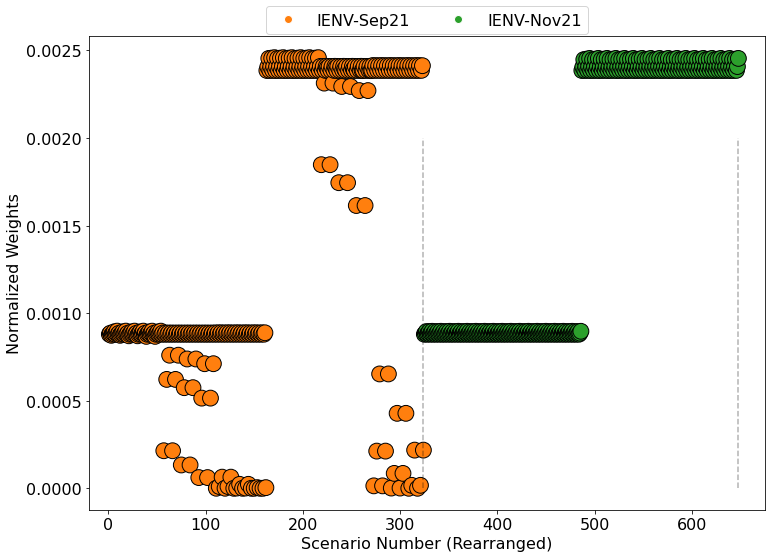

In [32]:
from matplotlib.lines import Line2D
###################################### Plotting ###################################
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize']=16

fig, ax = plt.subplots(figsize=(11,8))
plt.rcParams["font.serif"]
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors = {'IENV-Sep21':'tab:orange','IENV-Nov21':'tab:green'}
ax.scatter(df_final1['Ensemble Number'],df_final1['WeightN'],c=df_final1['IENV'].map(colors),s=250,edgecolors='k')
plt.plot([324,324],[0,0.002],'k--',alpha=0.3)
plt.plot([648,648],[0,0.002],'k--',alpha=0.3)

handles = [Line2D([0],[0],marker='o',color='w',markerfacecolor=v,label=k,markersize=8) for k,v in colors.items()]
ax.legend(title=None, handles=handles,ncol=3,loc='upper center',bbox_to_anchor=(0.5,1.08))
ax.set_xlim(-20,675)
ax.set_ylabel('Normalized Weights')
ax.set_xlabel('Scenario Number (Rearranged)')

plt.tight_layout()